<a href="https://colab.research.google.com/github/beeyan/Analytics/blob/master/Colab%20Notebooks/learning_numpy.jax/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### numpy.jaxを用いたアルゴリズムの実装一覧

In [0]:
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random, jit

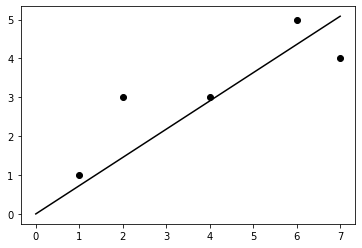

In [9]:
#回帰の実装

# 原点を通る直線で近似する
# 1次元のMSEの微分

def reg1dim1(x, y):
  a = np.dot(x, y) / (x**2).sum()
  return a

x = np.array([1, 2, 4, 6, 7]) # 入力
y = np.array([1, 3, 3, 5, 4]) # 出力
a = reg1dim1(x, y)

plt.scatter(x, y, color='k')
xmax = x.max()
plt.plot([0, xmax], [0, a*xmax], color="k")
plt.show()

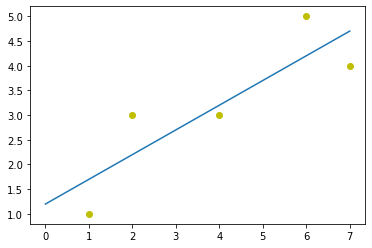

In [8]:
# 2次元のMSEの微分

def reg1dim2(x, y):
  n = len(x)
  a = ((np.dot(x, y) - y.sum() * x.sum() / n) /
       ((x**2).sum() -(x.sum()**2)/n))
  b = (y.sum() - a * x.sum()) / n
  return a, b

x = np.array([1, 2, 4, 6, 7])
y = np.array([1, 3, 3, 5, 4])
a, b = reg1dim2(x, y)

plt.scatter(x, y, color='y')
xmax = x.max()
plt.plot([0, xmax], [b, a * xmax + b])
plt.show()

### 線形回帰の実装

In [0]:
import jax.numpy as np
from scipy import linalg

class LinearRegression():

  def __init__(self):
    self.w_ = None
  
  def fit(self, X, t):
    if X.ndim == 1:
      X = X.reshape(X.shape[0], 1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)
    A = np.dot(Xtil.T, Xtil)
    b = np.dot(Xtil.T, t)
    self.w_ = linalg.solve(A, b)
  
  def predict(self, X):
    if X.ndim == 1:
      X = X.reshape(1, -1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0],1)
    Xtil = np.concatenate((ones, X), 1)
    return np.dot(Xtil, self.w_)

In [236]:
from mpl_toolkits.mplot3d import axes3d
n = 100
scale = 10

key = random.PRNGKey(0)
X = random.uniform(key, (n, 2), minval=0, maxval=1)*scale
w0 = 1
w1 = 2
w2 = 3

y = w0 +w1*X[:, 0] + w2*X[:, 1] + random.normal(key, (n,))

model = LinearRegression()
model.fit(X, y)
print('coefficient:', model.w_)
print('predict value from (1, 1):', model.predict(np.array([1, 1])))

coefficient: [1.0527477 2.0223231 2.9845057]
predict value from (1, 1): [6.0595765]


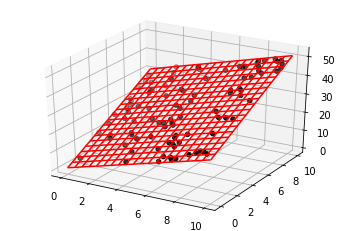

In [237]:
xmesh, ymesh = np.meshgrid(np.linspace(0, scale, 20),
                              np.linspace(0, scale, 20))
zmesh = (model.w_[0] 
          + model.w_[1] * xmesh.ravel() 
          + model.w_[2] * ymesh.ravel()).reshape(xmesh.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color = 'k')
ax.plot_wireframe(xmesh, ymesh, zmesh, color='r')
plt.show()

### 

In [141]:
import csv

PATH = '/content/drive/My Drive/Analytics/Colab Notebooks/learning_numpy.jax/'
Xy = []
with open(PATH+'winequality-red.csv') as fp:
  count = 0
  for row in csv.reader(fp, delimiter=";"):
    if count == 0:
      count += 1
      continue
    row = [float(s) for s in row]
    Xy.append(row)

Xy = np.array(Xy, dtype=np.float64)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [142]:
# 訓練/テスト用に分ける
random.shuffle(key, Xy)

train_X = Xy[:-1000, :-1]
train_y = Xy[:-1000, -1]
test_X = Xy[-1000:, :-1]
test_y = Xy[-1000:, -1]

model = LinearRegression()
model.fit(train_X, train_y)

y = model.predict(test_X)

print('first 5 answers and prediction: ')
for item in range(5):
  print('{:1.0f} {:5.3f}'.format(test_y[item], y[item]))
print()
print("RMSE: ", np.sqrt(((test_y - y)**2).mean()))

first 5 answers and prediction: 
6 5.574
4 5.140
6 5.436
5 5.153
6 5.436

RMSE:  0.66848594


/usr/local/lib/python3.6/dist-packages/jax/random.py:454: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.00974e-11): result may not be accurate.


### Ridge回帰の実装

In [0]:
import jax.numpy as np
from scipy import linalg

class RidgeRegression():
  def __init__(self, lambda_ = 1.):
    self.lambda_ = lambda_
    self.w_ = None
  
  def fit(self, X, t):
    if X.ndim == 1:
      X = X.reshape(X.shape[0], 1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)
    c = np.eye(Xtil.shape[1])
    A = np.dot(Xtil.T, Xtil) + self.lambda_ * c
    b = np.dot(Xtil.T, t)
    self.w_ = linalg.solve(A, b)
  
  def predict(self, X):
    if X.ndim == 1:
      X = X.reshape(1, -1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)
    return np.dot(Xtil, self.w_)

In [0]:
x = np.array([1, 2, 4, 6, 7])
y = np.array([1, 3, 3, 5, 4])

model = RidgeRegression(1.)
model.fit(x, y)
b, a = model.w_

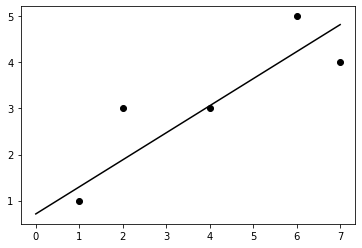

In [219]:
plt.scatter(x, y, color='k')
xmax = x.max()
plt.plot([0, xmax], [b, b + a*xmax], color='k')
plt.show()

In [222]:
from mpl_toolkits.mplot3d import axes3d
n = 100
scale = 10

key = random.PRNGKey(0)
X = random.uniform(key, (n, 2), minval=0, maxval=1)*scale
w0 = 1
w1 = 2
w2 = 3

y = w0 +w1*X[:, 0] + w2*X[:, 1] + random.normal(key, (n,))
model = RidgeRegression(1.)
model.fit(X, y)
print('coefficient:', model.w_)

coefficient: [1.0085129 2.025945  2.9873638]


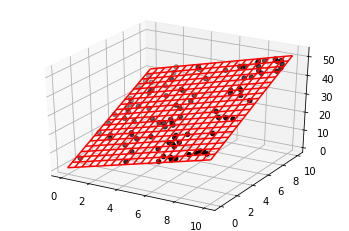

In [223]:
xmesh, ymesh = np.meshgrid(np.linspace(0, scale, 20),
                              np.linspace(0, scale, 20))
zmesh = (model.w_[0] 
          + model.w_[1] * xmesh.ravel() 
          + model.w_[2] * ymesh.ravel()).reshape(xmesh.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color = 'k')
ax.plot_wireframe(xmesh, ymesh, zmesh, color='r')
plt.show()

In [0]:
from jax.ops import index, index_update

x = np.arange(12)
y = 1 + 2*x

y = index_update(y, index[2], 20.)
y = index_update(y, index[4], 0.)
xmin = 0
xmax = 12
ymin = -1
ymax = 25

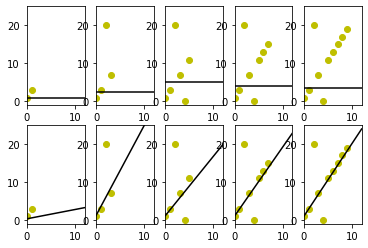

In [241]:
fig, axes = plt.subplots(nrows=2, ncols=5)
for item in range(5):
  axes[0, item].set_xlim([xmin, xmax])
  axes[0, item].set_ylim([ymin, ymax])
  axes[1, item].set_xlim([xmin, xmax])
  axes[1, item].set_ylim([ymin, ymax])

  xx = x[:2 + item * 2]
  yy = y[:2 + item * 2]

  axes[0, item].scatter(xx, yy, color='y')
  axes[1, item].scatter(xx, yy, color='y')

  model = LinearRegression()
  model.fit(xx, yy)

  xs = [xmin, xmax]
  ys = [model.w_[0] + model.w_[1] * xmin,
        model.w_[0] + model.w_[1] * xmin]
  axes[0, item].plot(xs, ys, color='k')

  model = RidgeRegression(10.)
  model.fit(xx, yy)

  xs = [xmin, xmax]
  ys = [model.w_[0] + model.w_[1] * xmin,
        model.w_[0] + model.w_[1] * xmax]
  axes[1, item].plot(xs, ys, color='k')

plt.show()

### 多項式回帰の実装

In [0]:
import jax.numpy as np
from scipy import linalg

class LinearRegression():

  def __init__(self):
    self.w_ = None
  
  def fit(self, X, t):
    if X.ndim == 1:
      X = X.reshape(X.shape[0], 1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)
    A = np.dot(Xtil.T, Xtil)
    b = np.dot(Xtil.T, t)
    self.w_ = linalg.solve(A, b)
  
  def predict(self, X):
    if X.ndim == 1:
      X = X.reshape(1, -1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0],1)
    Xtil = np.concatenate((ones, X), 1)
    return np.dot(Xtil, self.w_)


class PolynomialRegression:

  def __init__(self, degree):
    self.degree = degree
    self.w_ = None
  
  def fit(self, x, t):
    x_pow = []
    xx = x.reshape(len(x), 1)
    for item in range(1, self.degree + 1):
      x_pow.append(xx**item)
    mat = np.concatenate(x_pow, axis=1)

    linreg = LinearRegression()
    linreg.fit(mat, t)
    self.w_ = linreg.w_
  
  def predict(self, x):
    r = 0
    for item in range(self.degree + 1):
      r += x**item *self.w_[item]
    return r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: LinAlgWarning: Ill-conditioned matrix (rcond=8.88736e-33): result may not be accurate.
  app.launch_new_instance()


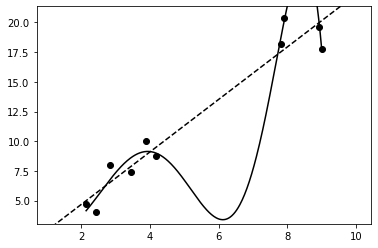

In [335]:
# 多項式回帰の検証
key = random.PRNGKey(5)

def f(x):
  return 1+ 2 * x

key = random.PRNGKey(6)
x = random.uniform(key, (10, ), minval=0, maxval=1) * 10
key = random.PRNGKey(16)
y = f(x) + random.normal(key, (10,))

# 多項式回帰
model = PolynomialRegression(15)
model.fit(x, y)

plt.scatter(x, y, color='k')
plt.ylim([y.min() - 1, y.max() + 1])
xx = np.linspace(x.min(), x.max(), 300)
yy = np.array([model.predict(u) for u in xx])
plt.plot(xx, yy, color='k')

# 線形回帰
model = LinearRegression()
model.fit(x, y)
b, a = model.w_
x1 = x.min() - 1
x2 = x.max() + 1
plt.plot([x1, x2], [a*x1+b, a*x2+b], color='k', linestyle='dashed')

plt.show()

### Lassoの実装

In [0]:
def soft_thresholding(x, y):
  return np.sign(x) * max(abs(x) - y, 0)


In [0]:
class Lasso():
  def __init__(self, lambda_, tol=0.0001, max_iter=1000):
    self.lambda_ = lambda_
    self.tol = tol
    self.max_iter = max_iter
    self.w_ = None
  
  def fit(self, X, t):
    n, d = X.shape
    self.w_ = np.zeros(d + 1)
    avgl1 = 0.
    for _ in range(self.max_iter):
      avgl1_prev = avgl1
      self._update(n, d, X, t)
      avgl1 = np.abs(self.w_).sum() / self.w_.shape[0]
      if abs(avgl1 - avgl1_prev) <= self.tol:
        break
  
  def _update(self, n, d, X, t):
    init = (t - np.dot(X, self.w_[1:])).sum() / n
    self.w_ = index_update(self.w_, index[0], float(init))
    w0vec = np.ones(n) * self.w_[0]
    for k in range(d):
      ww = self.w_[1:]
      ww = index_update(ww, index[k], 0.)
      q = np.dot(t - w0vec - np.dot(X, ww), X[:, k])
      r = np.dot(X[:, k], X[:, k])
      self.w_ = index_update(self.w_, index[k + 1], soft_thresholding(q / r, self.lambda_))
  
  def predict(self, X):
    if X.ndim == 1:
      X = X.reshape(X.shape[0], 1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)
    return np.dot(Xtil, self.w_)

In [348]:
# Lassoの予測
import csv

PATH = '/content/drive/My Drive/Analytics/Colab Notebooks/learning_numpy.jax/'
Xy = []
with open(PATH+'winequality-red.csv') as fp:
  count = 0
  for row in csv.reader(fp, delimiter=";"):
    if count == 0:
      count += 1
      continue
    row = [float(s) for s in row]
    Xy.append(row)

Xy = np.array(Xy, dtype=np.float64)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [349]:
# 訓練/テスト用に分ける

key = random.PRNGKey(6)
random.shuffle(key, Xy)

train_X = Xy[:-1000, :-1]
train_y = Xy[:-1000, -1]
test_X = Xy[-1000:, :-1]
test_y = Xy[-1000:, -1]

/usr/local/lib/python3.6/dist-packages/jax/random.py:454: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation
  warnings.warn(msg, FutureWarning)


In [369]:
for lambda_ in [1., 0.1, 0.01]:
  model = Lasso(lambda_)
  model.fit(train_X, train_y)
  y = model.predict(test_X)
  print('--- lambda = {}---'.format(lambda_))
  print('coefficient: ')
  print(model.w_)
  mse = ((y - test_y)**2).mean()
  print("MSE: {:.3f}".format(mse))

--- lambda = 1.0---
coefficient: 
[ 5.609349  0.       -0.        0.        0.       -0.       -0.
 -0.        0.       -0.        0.        0.      ]
MSE: 0.667
--- lambda = 0.1---
coefficient: 
[ 5.6103      0.         -0.08130371  0.57407117  0.         -1.5371377
 -0.         -0.         -0.         -0.          0.          0.        ]
MSE: 0.619
--- lambda = 0.01---
coefficient: 
[ 5.6250834   0.         -0.8697946   0.37194854  0.         -3.1466718
 -0.         -0.          0.          0.          0.87230563  0.        ]
MSE: 0.527


### LogisticRegression

In [0]:
THRESHMIN = 1e-10

class LogisticRegression():
  def __init__(self, tol=0.001, max_iter=3, random_seed=0):
    self.tol = tol
    self.max_iter = max_iter
    self.key = random.PRNGKey(random_seed)
    self.w_ = None
  
  def fit(self, X, y):
    self.w_ = random.normal(self.key, (X.shape[1] + 1, ))
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)